# Домашнее задание. Композиции алгоритмов
В этом домашнем задании вам предстоит обучить два вида композиций алгоритмов: бэггинг и бустинг.

## Постановка задачи
Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week

## Метрика качества
В качестве целевой метрики мы будем использовать ROC-AUC. Об этой метрике мы говорили в модуле о метриках. Как вы помните, для измерения ROC-AUC требуются вероятности принадлежности к классам. Для решающих деревьев вероятность принадлежности к классу вычисляется как доля объектов из обучающей выборки в соответствующем листе. Для алгоритма, который принимает решение взвешенным голосованием, вероятность вычисляется как среднее взвешенное значение вероятностей по всем алгоритмам в композиции.

## Ход работы
* Первым делом вы произведете загрузку и обработку данных. В частности, вам необходимо будет закодировать категориальные признаки с помощью One-hot encoding.
* Сначала мы построим для нашей задачи обычный случайный лес и измерим его качество. Мы подберем оптимальный гиперпараметр "глубина дерева" для случайного леса.
* Далее мы обучим алгоритм градиентного бустинга с помощью библиотеки Catboost. Catboost --- это библиотека для градиентного бустинга, которая автоматически обрабатывает категориальные признаки. Поэтому для этого пункта вам нужно будет использовать не One-hot признаки, а изначальные категориальные признаки.

## Оценивание
В этом домашнем задании данные разделены на две части:
* [`data_train.csv`](https://drive.google.com/file/d/1qKakViWhNT1yTiM66V9hxADAVCYTL0PO/view?usp=share_link). Для этих данных вам известно значение целевой переменной. Эти данные вы будете использовать для обучения.
* [`data_scoring.csv`](https://drive.google.com/file/d/1tguHTZm9-sUwTRzqAEuqLRUzKHqkvVmQ/view?usp=share_link). На этих данных вы должны будете применить готовую модель, а затем сдать результаты в Stepik. Вам необходимо будет сдать результат работы двух моделей: случайного леса и градиентного бустинга.



## Часть 1. Загрузка и обработка данных
Загрузка данных будет состоять из следующих шагов:
* Загрузка из файла;
* Работа с пропущенными значениями;
* Выделение целевой переменной;
* Разбиение данных на вещественные и категориальные;
* One-hot кодирование категориальных данных;
* Разбиение данных на train и test.

Затем все эти шаги (кроме последнего) необходимо будет применить к `data_scoring`.

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
!gdown 1qKakViWhNT1yTiM66V9hxADAVCYTL0PO #эта команда скачивает файл data_train.csv и помещает его в корневую директорию Colab. Очень удобно!

zsh:1: command not found: gdown


In [4]:
data = pd.read_csv('data_train.csv')

In [5]:
data.shape

(14734, 14)

In [6]:
data[:10]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
5,18,Private,446771,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,25,<=50K
6,31,Federal-gov,108464,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,<=50K
7,18,?,423460,11th,7,Never-married,?,Own-child,White,Male,0,0,36,<=50K
8,25,Private,110138,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,<=50K
9,53,Federal-gov,167410,Bachelors,13,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male,0,0,40,<=50K


### Задание
Проведите с данными необходимые операции:

* Замените все знаки "?" на `np.nan`.
* Найдите все столбцы со значениями NaN. Напечатайте их названия.
* Выделите вектор ответов. Закодируйте правильные ответы 0 и 1:
    * '<=50K' -> 0;
    * '>50K' -> 1.
* Сохраните их в отдельную переменную `y` типа `np.array`.
* Удалите из data правильные ответы.

In [7]:
data = data.replace('?', np.nan)
y = data['>50K,<=50K']
y = y.replace('>50K', 1)
y = y.replace('<=50K', 0)
data = data.drop('>50K,<=50K', axis = 1)
data[:10]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40
5,18,Private,446771,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,25
6,31,Federal-gov,108464,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40
7,18,NaN,423460,11th,7,Never-married,NaN,Own-child,White,Male,0,0,36
8,25,Private,110138,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40
9,53,Federal-gov,167410,Bachelors,13,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male,0,0,40


**Вопрос**. В каких колонках присутствуют пропущенные значения?

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14734 entries, 0 to 14733
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             14734 non-null  int64 
 1   workclass       13874 non-null  object
 2   fnlwgt          14734 non-null  int64 
 3   education       14734 non-null  object
 4   education-num   14734 non-null  int64 
 5   marital-status  14734 non-null  object
 6   occupation      13870 non-null  object
 7   relationship    14734 non-null  object
 8   race            14734 non-null  object
 9   sex             14734 non-null  object
 10  capital-gain    14734 non-null  int64 
 11  capital-loss    14734 non-null  int64 
 12  hours-per-week  14734 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 1.5+ MB


**Вопрос**. Какие из признаков являются вещественными?

Выделите вещественные и категориальные признаки.

In [9]:
real_columns = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

real_data = data[real_columns]
real_data[:10]

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40
5,18,446771,10,0,0,25
6,31,108464,12,0,0,40
7,18,423460,7,0,0,36
8,25,110138,9,0,0,40
9,53,167410,13,0,0,40


In [10]:
cat_columns = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex"]

cat_data = data[cat_columns]
cat_data[:10]

,workclass,education,marital-status,occupation,relationship,race,sex
0,Local-gov,HS-grad,Never-married,Farming-fishing,Not-in-family,Black,Male
1,Private,Some-college,Divorced,Sales,Not-in-family,White,Male
2,Local-gov,Bachelors,Married-civ-spouse,Prof-specialty,Own-child,White,Male
3,Private,Some-college,Never-married,Sales,Own-child,White,Female
4,Private,Bachelors,Married-civ-spouse,Tech-support,Husband,White,Male
5,Private,Some-college,Never-married,Adm-clerical,Own-child,White,Male
6,Federal-gov,Assoc-acdm,Married-civ-spouse,Tech-support,Husband,White,Male
7,NaN,11th,Never-married,NaN,Own-child,White,Male
8,Private,HS-grad,Never-married,Other-service,Not-in-family,White,Male
9,Federal-gov,Bachelors,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male


### Задание
Выделите One-hot признаки из данных с помощю объекта `OneHotEncoder` из модуля `sklearn.preprocessing`.

In [11]:
from sklearn.preprocessing import OneHotEncoder

In [12]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe = ohe.fit(cat_data)
one_hot_data = pd.DataFrame(ohe.transform(cat_data), index=cat_data.index, columns=ohe.get_feature_names_out())
one_hot_data[:10]

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,workclass_nan,education_10th,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Наконец, разобьем данные на train и test в соотношении 70:30.

In [13]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_real_data, test_real_data, \
train_cat_data, test_cat_data, train_one_hot_data, test_one_hot_data, \
y_train, y_test = train_test_split(data, real_data,
                                   cat_data, one_hot_data,
                                   y, train_size=0.7)

### Задание
Проделайте все то же самые операции для scoring_data.
* Загрузите данные из файла data_scoring.csv;
* Замените "?" на `np.nan`;
* Выделите числовые и категориальные данные;
* Закодируйте категориальные данные с помощью уже созданного `ohe`. Новый объект класса `OneHotEncoding` создавать не нужно. Используйте метод `ohe.transform`.

In [14]:
!gdown 1tguHTZm9-sUwTRzqAEuqLRUzKHqkvVmQ

zsh:1: command not found: gdown


In [15]:
from sklearn.preprocessing import OneHotEncoder
scoring_data = pd.read_csv('data_scoring.csv')
scoring_data = scoring_data.replace('?', np.nan)
scoring_real_data = scoring_data[["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]]
scoring_cat_data = scoring_data[["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex"]]
scoring_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scoring_ohe = scoring_ohe.fit(scoring_cat_data)
scoring_one_hot_data = pd.DataFrame(scoring_ohe.transform(scoring_cat_data), index=scoring_cat_data.index, columns=scoring_ohe.get_feature_names_out())

## Часть 2. Обучение случайного леса
Мы будем использовать модель `RandomForestClassifier` из `sklearn.ensemble`. Вам предстоит подобрать для случайного леса оптимальный параметр глубины. Количество деревьев в этом задании мы будем использовать постоянным и равным 100.

Выбор параметра мы будем производить с помощью кросс-валидации на 5 фолдов, используя метод `cross_val_score` из `sklearn.model_selection`. Затем мы обучим окончательную модель на всем `train_data`, а на `test_data` будем считать итоговое качество.

Отметим, что для моделей `sklearn` мы не можем по умолчанию использовать категориальные признаки. Поэтому мы будем использовать `train/test_one_hot_data`.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

Создадим полную матрицу объекты-признаки. Используем числовые и one-hot данные.

In [17]:
train_data_for_forest = pd.concat([train_real_data, train_one_hot_data], axis='columns')
test_data_for_forest = pd.concat([test_real_data, test_one_hot_data], axis='columns')
train_data_for_forest = train_data_for_forest[sorted(train_data_for_forest.columns)]
test_data_for_forest = test_data_for_forest[sorted(test_data_for_forest.columns)]
print(train_data_for_forest[:10])

       age  capital-gain  capital-loss  education-num  education_10th  \
10315   19             0             0             10             0.0   
1971    55             0             0              9             0.0   
1172    52             0             0             14             0.0   
8104    33          3674             0             10             0.0   
13803   34             0             0             10             0.0   
10723   72             0             0              9             0.0   
5221    21             0             0             11             0.0   
13540   45             0             0              9             0.0   
14445   28             0             0             10             0.0   
3682    56             0             0             10             0.0   

       education_11th  education_12th  education_1st-4th  education_5th-6th  \
10315             0.0             0.0                0.0                0.0   
1971              0.0             0.0 

### Задание
Выберите оптимальный параметр max_depth от 3 до 19 включительно для модели случаного леса. Используйте кросс-валидацию. Для каждой глубины посчитайте среднее по фолдам значение метрики ROC-AUC и запишите получившиеся данные в массив `rf_metrics`. Используйте 5 фолдов для кросс-валидации.

**Совет**. Для ускорения работы функции `cross_val_score` используйте параметр n_jobs=-1.

In [18]:
depths = np.arange(3, 20)
rf_metrics = []

for depth in depths:
    scores = cross_val_score(RandomForestClassifier(n_estimators=100, max_depth=depth), train_data_for_forest, y_train, cv=5, n_jobs=-1, scoring="roc_auc")

    rf_metrics.append(np.mean(scores))

Построим график получившейся метрики в зависимости от параметра `depth`.

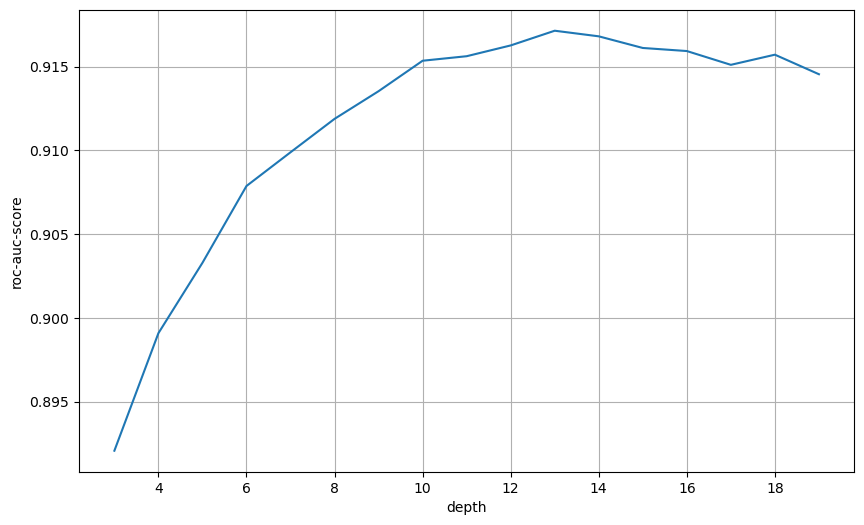

In [19]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(3, 20), rf_metrics)
plt.xlabel('depth')
plt.ylabel('roc-auc-score')
plt.grid()

### Задание
Выберите оптимальное значение глубины и обучите для этого значения единственную модель `RandomForestClassifier` на всех обучающих данных `train_data_for_forest`. Предскажите вероятность класса 1 на обучающих и тестовых данных. Сохраните их в переменные `train_y_pred_forest` и `test_y_pred_forest`. Используйте метод `predict_proba`.

In [20]:
best_depth = 14

model = RandomForestClassifier(n_estimators=100, max_depth=best_depth)

model.fit(train_data_for_forest, y_train)


train_y_pred_forest = model.predict_proba(train_data_for_forest)[:, 1]
test_y_pred_forest = model.predict_proba(test_data_for_forest)[:, 1]
print(train_y_pred_forest)
print(test_y_pred_forest)

[6.20074563e-04 3.96973555e-01 8.34000438e-01 ... 5.17183605e-01
 1.14080176e-01 2.36676933e-03]
[0.86978867 0.19255764 0.20563297 ... 0.0623436  0.15032543 0.00736592]


In [21]:
from sklearn.metrics import roc_curve, roc_auc_score

In [22]:
from sklearn.metrics import roc_auc_score
train_auc = roc_auc_score(y_train, train_y_pred_forest)
test_auc = roc_auc_score(y_test, test_y_pred_forest)

Проверим, что мы получили достаточно хорошие значения для `test_auc`.

In [23]:
assert test_auc > 0.90

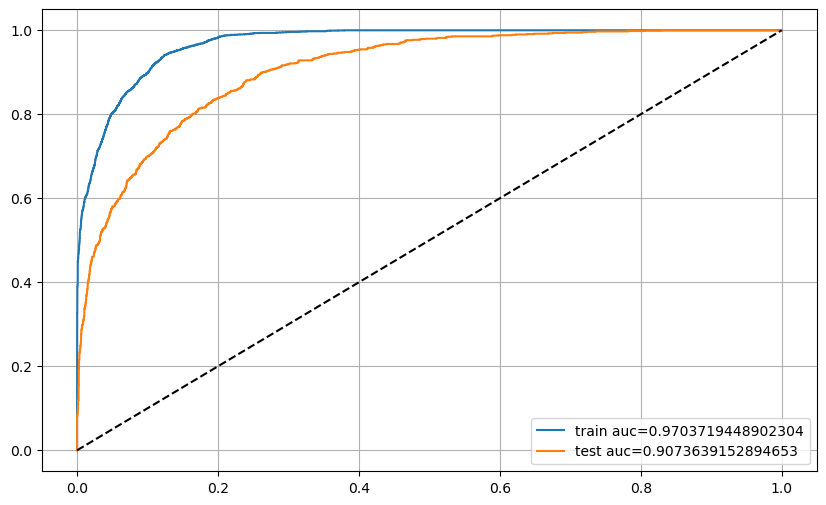

In [24]:
from sklearn import metrics
plt.figure(figsize=(10,6))
plt.plot(*metrics.roc_curve(y_train, train_y_pred_forest)[:2],
         label=f'train auc={train_auc}')
plt.plot(*metrics.roc_curve(y_test, test_y_pred_forest)[:2],
         label=f'test auc={test_auc}')


plt.plot([0,1], [0,1], '--', color='black')
plt.legend()
plt.grid()

### Задание
Создайте датасет `scoring_data_for_forest` и предскажите на нем целевую переменную.

In [25]:
import pandas as pd

import sys
sys.setrecursionlimit(100000)
scoring_data_for_forest = pd.read_csv('data_scoring.csv')
scoring_data_for_forest = scoring_data_for_forest.replace('?', np.nan)
scoring_real_data = scoring_data_for_forest[real_columns]
scoring_cat_data = scoring_data_for_forest[cat_columns]
scoring_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scoring_ohe = scoring_ohe.fit(scoring_cat_data)
scoring_one_hot_data = pd.DataFrame(scoring_ohe.transform(scoring_cat_data), index=scoring_cat_data.index, columns=scoring_ohe.get_feature_names_out())
scoring_data_for_forest = pd.concat([scoring_real_data, scoring_one_hot_data], axis='columns')
scoring_data_for_forest.loc[:, "marital-status_Married-AF-spouse"] = 0
scoring_data_for_forest.loc[:, "occupation_Armed-Forces"] = 0
scoring_data_for_forest.loc[:, "workclass_Never-worked"] = 0
scoring_data_for_forest.loc[:, "workclass_Without-pay"] = 0
scoring_data_for_forest = scoring_data_for_forest[sorted(scoring_data_for_forest.columns)]
print(scoring_data_for_forest[:10])
scoring_y_pred_forest = model.predict_proba(scoring_data_for_forest)[:, 1]
scoring_y_pred_forest

   age  capital-gain  capital-loss  education-num  education_10th  \
0   17             0             0              6             1.0   
1   31             0             0             13             0.0   
2   61             0             0              9             0.0   
3   60             0             0              9             0.0   
4   56             0          1980             10             0.0   
5   55             0             0              9             0.0   
6   25             0             0              9             0.0   
7   62             0             0              9             0.0   
8   39             0             0             10             0.0   
9   44             0             0             10             0.0   

   education_11th  education_12th  education_1st-4th  education_5th-6th  \
0             0.0             0.0                0.0                0.0   
1             0.0             0.0                0.0                0.0   
2             0

array([3.61879812e-04, 1.16924165e-01, 2.96521493e-01, ...,
       3.87141402e-02, 1.92912929e-01, 8.52421822e-01])

Сохраним scoring_y_pred_forest. Отправьте их на Stepik, полностью скопировав содержимое файла и вставив их вместо "<ВАШ КОД. Вставьте сюда list вероятностей, предсказанных случайным лесом на data_scoring.csv>" так, чтобы переменная answer содержала список вероятностей в нужном порядке.

In [26]:
with open('scoring_y_pred_forest.txt', "w") as f:
    f.write(', '.join([str(item) for item in scoring_y_pred_forest]))

Для посылки на kaggle обычно используют функцию `.to_csv`, как ниже, но нам этот код не понадобится:

In [27]:
pd.Series(scoring_y_pred_forest).to_csv('scoring_y_pred_forest.csv', header=None, index=None)

## Часть 3. Обучение градиентного бустинга
Мы будем использовать библиотеку Catboost. Catboost --- это библиотека для градиентного бустинга от компании Яндекс. Она, как следует из названия, отличается удобной работой с данными вообще и категориальными признаками с частности. Про Catboost можно прочитать в [официальной документации](https://catboost.ai/en/docs/concepts/python-usages-examples) и в статье на [Хабре](https://habr.com/ru/post/599827/).

<img src="https://avatars.mds.yandex.net/i?id=53d991f7cac35c76bf747793019c39fb-3751806-images-thumbs&n=13&exp=1" style="height:400px; width:800px">

Обратите внимание на следующие моменты:
* В Catboost можно сразу передавать категориальные признаки без предварительного кодирования.
* В Catboost для категориальных признаков необходимо заполнять пропущенные значения. Мы будем заполнять их значениями `'unknown'`.
* Для работы с данными в Catboost [есть специальный класс](https://catboost.ai/en/docs/concepts/python-reference_pool), который называется `Pool`. Прочитать о нем можно также в [примерах использования](https://catboost.ai/en/docs/concepts/python-usages-examples).
* Для кросс-валидации в Catboost [есть специальный класс](https://catboost.ai/en/docs/concepts/python-reference_cv) `cv`. Об использовании можно прочитать в статье на [Хабре](https://habr.com/ru/post/599827/).
* Собственно, основная модель для классификации в Catboost --- это `CatBoostClassifier`.

Для установки `catboost` вы можете выполнить следующую команду.

In [28]:
!pip install catboost

Импортируем все необходимые классы.

In [29]:
from catboost import CatBoostClassifier, Pool, cv

### Задание
Заполните пропуски в данных `train_cat_data` и `test_cat_data` значением `'unknown'`. Используйте метод `fillna`.

In [30]:
train_cat_data = train_cat_data.fillna('unknown')
test_cat_data = test_cat_data.fillna('unknown')

### Задание
Создайте новые наборы данных для train и test, состоящие из `[train/test]_real_data` и `[train/test]_cat_data`. Используйте `pd.concat`. Затем создайте обучающий и тестовый `Pool` (за вас мы выделили номера категориальных признаков).

In [32]:
train_data_for_boosting = pd.concat([train_real_data, train_cat_data], axis='columns')
test_data_for_boosting = pd.concat([test_real_data, test_cat_data], axis='columns')
print(train_data_for_boosting[:10])

cat_features = np.arange(train_cat_data.shape[1]) + train_real_data.shape[1]
print(cat_features[:10])

train_dataset = Pool(data=train_data_for_boosting,
                     label=y_train,
                     cat_features=cat_features)

test_dataset = Pool(data=test_data_for_boosting,
                     label=y_test,
                     cat_features=cat_features)

       age  fnlwgt  education-num  capital-gain  capital-loss  hours-per-week  \
10315   19  184710             10             0             0              30   
1971    55  130957              9             0             0              45   
1172    52  205767             14             0             0              40   
8104    33   40681             10          3674             0              16   
13803   34  113838             10             0             0              45   
10723   72  166253              9             0             0               2   
5221    21   34816             11             0             0              12   
13540   45  264052              9             0             0              40   
14445   28   25955             10             0             0              40   
3682    56   78090             10             0             0              48   

              workclass     education      marital-status      occupation  \
10315           Private  Some-c

Для каждого значения depth от 3 до 16 включительно используйте функцию `cv` для подсчета результатов кросс-валидации. Затем посчитайте среднее по фолдам значение метрики ROC-AUC с последней итерации и запишите получившиеся данные в массив `boosting_metrics`.

Обратите внимание, что функция `cv` должна принимать следующие параметры:
* `pool` (используйте `train_dataset`)
* `params` (используйте параметры, указанные в коде)
* `fold_count` (положите равным 5).

Функция cv возвращает pd.DataFrame с метриками обучения. Вам понадобится колонка `'test-AUC-mean'` и последняя строчка. Обратите внимание, что обучение занимает значительное время! Сначала можете попробовать выполнить этот код для небольшого массива `depths`, чтобы было легче дебагать.

In [31]:
depths = np.arange(3, 17)
boosting_metrics = []

for depth in depths:
    params = {"iterations": 100,
              "depth": depth,
              "loss_function": "Logloss",
              "custom_loss": "AUC",
              "verbose": False}

    scores = cv(train_dataset,
            params,
            fold_count=5)
    print(scores.iloc[-1][5])
    boosting_metrics.append(scores.iloc[-1][5])

Training on fold [0/5]

bestTest = 0.3256521331
bestIteration = 99

Training on fold [1/5]

bestTest = 0.3331749516
bestIteration = 99

Training on fold [2/5]

bestTest = 0.3367861476
bestIteration = 99

Training on fold [3/5]

bestTest = 0.3243598816
bestIteration = 99

Training on fold [4/5]

bestTest = 0.3205940158
bestIteration = 99

0.9087258692531917
Training on fold [0/5]

bestTest = 0.3182477301
bestIteration = 99

Training on fold [1/5]

bestTest = 0.3272034493
bestIteration = 99

Training on fold [2/5]

bestTest = 0.3310079645
bestIteration = 99

Training on fold [3/5]

bestTest = 0.317358113
bestIteration = 99

Training on fold [4/5]

bestTest = 0.3145624175
bestIteration = 99

0.9108989244754353
Training on fold [0/5]

bestTest = 0.312932254
bestIteration = 99

Training on fold [1/5]

bestTest = 0.3227141513
bestIteration = 99

Training on fold [2/5]

bestTest = 0.3258959206
bestIteration = 99

Training on fold [3/5]

bestTest = 0.3136700149
bestIteration = 99

Training on 

Построим график получившейся метрики в зависимости от параметра `depth`. Сравним его с тем же графиком для метрик случайного леса.

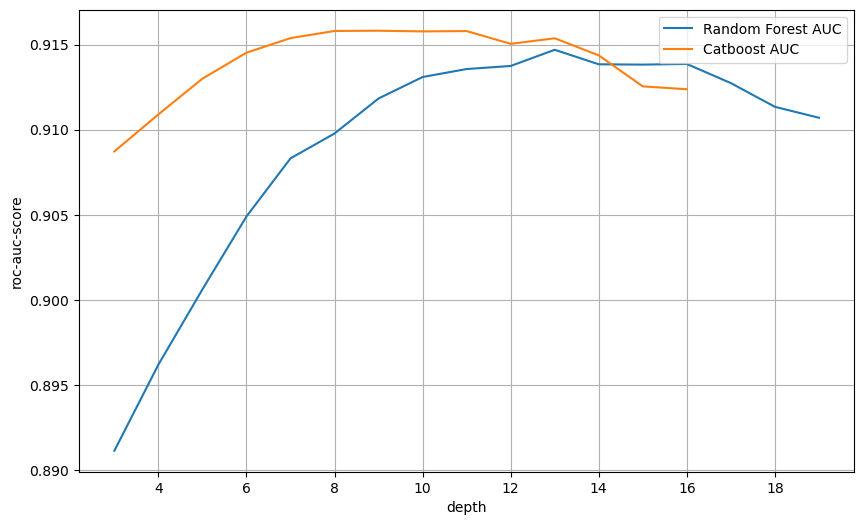

In [32]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(3, 20), rf_metrics, label='Random Forest AUC')
plt.plot(np.arange(3, 17), boosting_metrics, label='Catboost AUC')
plt.xlabel('depth')
plt.ylabel('roc-auc-score')
plt.grid()
plt.legend()

Ответье на следующие вопросы:
* Для какой модели общие результаты получились лучше? Если лучше результаты получились у бэггинга, как вы думаете, получится ли у бустинга отыграться на полной выборке и при большем количестве деревьев?
* Какова получилась оптимальная глубина для бустинга?
* Как она отличается от оптимальной глубины для бэггинга?

### Задание
Мы нашли оптмальную глубину. Обучите для этого значения глубины один `CatBoostClassifier` со следующими параметрами:
* `iterations=500` (именно 500, потому что качества с сотней деревьев может не хватить!)
* `depth =` глубина, которую вы нашли
* `loss_function='Logloss'`
* `verbose=False` (чтобы не было лишнего вывода).

Обучение производится с помощью метода `fit`, который принимает единственный аргумент --- `Pool` с данными. В данном случае используйте `train_dataset`.

Предскажите значения на `train_dataset` и `test_dataset`. Это делается методом `predict_proba` (устроен так же, как и в `sklearn`).

In [33]:
best_depth = 10

model = CatBoostClassifier(iterations = 500, depth = best_depth, loss_function='Logloss', verbose=False)

model.fit(train_dataset)


train_y_pred_boosting = model.predict_proba(train_dataset)[:, 1]
test_y_pred_boosting = model.predict_proba(test_dataset)[:, 1]

### Задание
Вычислите ROC-AUC на обучающем и тестовом множестве.

In [34]:
train_auc = roc_auc_score(y_train, train_y_pred_boosting)
test_auc = roc_auc_score(y_test, test_y_pred_boosting)

Проверим, что мы получили достаточно хорошие значения для `test_auc`.

In [35]:
assert test_auc > 0.915

Построим ROC-кривые для получившейся модели.

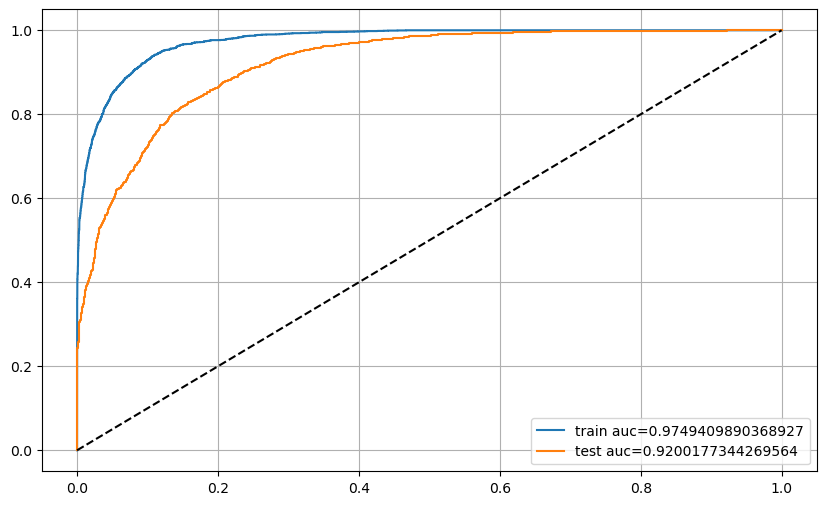

In [36]:
plt.figure(figsize=(10,6))
plt.plot(*roc_curve(y_train, train_y_pred_boosting)[:2],
         label=f'train auc={train_auc}')
plt.plot(*roc_curve(y_test, test_y_pred_boosting)[:2],
         label=f'test auc={test_auc}')

plt.plot([0,1], [0,1], '--', color='black')

plt.legend()
plt.grid()

### Задание
Примените построенную модель к данным `scoring_data`. Для этого повторите все шаги, которые вы делали с тестовыми данными:
* Заполнение пропущенных значений
* Конкатенация числовых и категориальных данных
* Создание `scoring_dataset` (здесь не нужно передавать аргумент `label`, так как мы их не знаем)
* Предсказание вероятностей 1 класса

In [37]:
scoring_cat_data = scoring_cat_data.fillna('unknown')
scoring_data_for_boosting = pd.concat([scoring_real_data, scoring_cat_data], axis='columns')
scoring_dataset = Pool(data=scoring_data_for_boosting,
                       label = None,
                       cat_features=cat_features)
scoring_y_pred_boosting = model.predict_proba(scoring_dataset)[:, 1]

Сохраним предсказанные значения. Отправьте их на Stepik.

In [38]:
with open('scoring_y_pred_boosting.txt', "w") as f:
    f.write(', '.join([str(item) for item in scoring_y_pred_boosting]))